In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy
from collections import defaultdict
import xml.etree.ElementTree as ET
import os
import numpy as np
import random
import copy
import pandas as pd
import xmltodict
from tqdm import tqdm

In [3]:
def load_from_xml(path):
    """

    :param path: path file

    :return: dict[frame_num] = [[x1, y1, x2, y2]]
    """
    
    with open(path) as f:
        tracks = xmltodict.parse(f.read())['annotations']['track']

    gt = defaultdict(list)
    num_iter = 0
    for track in tracks:
        label = track['@label']
        boxes = track['box']
        for box in boxes:
            if label == 'car':
                frame=int(box['@frame'])
                frame = f'f_{frame}'
                gt[frame].append(
                    [float(box['@xtl']),
                    float(box['@ytl']),
                    float(box['@xbr']),
                    float(box['@ybr'])]
                )
                num_iter += 1

            else:
                continue

    return gt, num_iter

In [4]:
def load_from_txt(path):
    """
    :param path: path file

    :return: list = [[frame,x1, y1, x2, y2, conf]]
    """
    frame_list = []
    with open(path) as f:
        lines = f.readlines()
   
    for l in lines:
        ll = l.split(',')
        frame = f'f_{int(ll[0]) - 1}'
        frame_list.append([frame,float(ll[2]), float(ll[3]),
                                            float(ll[2]) + float(ll[4]), float(ll[3])+float(ll[5]),ll[6]])
        


    return frame_list

In [5]:
def generate_noisy_boxes(gt_boxes, del_prob,gen_prob, mean, std,frame_shape=[1080, 1920]):
    """
    :gt_boxes: ground truth bounding boxes dict
    :del_prob: probability to delete bounding boxes
    :gen_prob: probability to generate bounding boxes
    :return: list with the noisy bounding boxes list = [[frame,x1, y1, x2, y2]]
    """
    noisy_bboxes = []
    gt_total = 0
    for frame,bboxes in gt_boxes.items():
        for bbox in bboxes:
            gt_total += 1
            if np.random.random() > del_prob:
                xtl, ytl, xbr, ybr = bbox
                noise = np.random.normal(mean,std,4)
                noisy_bboxes.append([frame,xtl+noise[0], ytl+noise[1], xbr+noise[2], ybr+noise[3]])
                w = xbr - xtl
                h = ybr - ytl

        if np.random.random() <= gen_prob:
            x = np.random.randint(w, frame_shape[1]-w)
            y = np.random.randint(h, frame_shape[0]-h)
            noisy_bboxes.append([frame,x-w/2, y-w/2, x+w/2, y+w/2])


    return noisy_bboxes


In [6]:
def iou(box1, box2):
    if len(box1) > 4:
        box1=box1[:4]
    x11, y11, x12, y12 = box1
    x21, y21, x22, y22 = box2
    xA = np.maximum(x11, x21)
    yA = np.maximum(y11, y21)
    xB = np.minimum(x12, x22)
    yB = np.minimum(y12, y22)
    interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / np.float64(boxAArea + boxBArea - interArea)
    return iou

In [7]:
def mean_AP_Pascal_VOC(gt_boxes,N_gt,predicted_boxes,iou_th):
    """
    :gt_boxes: ground truth bounding boxes dict
    :N_gt: Total of ground truth bounding boxes
    :predicted_boxes: predicted bounding boxes
    :return: mean IOU, average precision
    """
    mIOU = 0
    tp = np.zeros(len(predicted_boxes))
    fp = np.zeros(len(predicted_boxes))
    gt_detected = copy.deepcopy(gt_boxes)

    mIOU_frame = {}
    for i in range(len(predicted_boxes)):
        frame = predicted_boxes[i][0]
        predicted = predicted_boxes[i][1:5]
        gt = gt_detected[frame]
        iou_score = []
        if len(gt) != 0:
            for b in range(len(gt)):
                iou_score.append(iou(gt[b],predicted))
            id = np.argmax(iou_score)
            max_iou = iou_score[id]
            mIOU += max_iou
            # Save max iou for each frame
            if frame not in mIOU_frame:
                mIOU_frame[frame] = []
            mIOU_frame[frame].append(max_iou)

            if max_iou >= iou_th:
                if len(gt_detected[frame][id]) == 4:
                    gt_detected[frame][id].append(True)
                    tp[i] = 1
                else:
                    fp[i] = 1
            else:
                fp[i] = 1

    tp = np.cumsum(tp)
    fp = np.cumsum(fp)

    recall = tp/ float(N_gt)
    precision = tp/np.maximum(tp + fp, np.finfo(np.float64).eps)

    ap = 0.0
    for t in np.arange(0.0, 1.1, 0.1):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap = ap + p / 11.0

    return mIOU/len(predicted_boxes), mIOU_frame, ap

In [8]:
def compute_confidences_ap(gt_boxes,N_gt,predicted_boxes,N=10,iou_th = 0.5):
    """ 
    Randomly generates the order of the bounding boxes to calculate the average precision (N times). 
    Average values will be returned.
    """
    ap_scores = []
    
    for i in tqdm(range(N)):
        random.shuffle(predicted_boxes)
        mIOU,_, ap = mean_AP_Pascal_VOC(gt_boxes,N_gt,predicted_boxes,iou_th)
        ap_scores.append(ap)
        

    return sum(ap_scores)/len(ap_scores),mIOU

TASK 1.1

In [9]:
gt_boxes,total = load_from_xml('/home/guillem/mcv-m6-2023-team6/dataset/ai_challenge_s03_c010-full_annotation.xml')
df = pd.DataFrame(columns=['mean','std','delete_probability','generate_probability','mIOU','mAP'])

NOISE PARAMETERS

In [9]:
mean = [-2,0,2]
std = [2,5,10,15]

for i in range(len(mean)):
    noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.1,gen_prob=0.1,mean=mean[i],std=1)
    mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
    df.at[i,'mean'] = mean[i]
    df.at[i,'std'] = 1
    df.at[i,'delete_probability'] = 0.1
    df.at[i,'generate_probability'] = 0.1
    df.at[i,'mIOU'] = mIOU
    df.at[i,'mAP'] = mAP


for i in range(len(std)):
    noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.1,gen_prob=0.1,mean=0,std=std[i])
    mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
    df.at[i+3,'mean'] = 0
    df.at[i+3,'std'] = std[i]
    df.at[i+3,'delete_probability'] = 0.1
    df.at[i+3,'generate_probability'] = 0.1
    df.at[i+3,'mIOU'] = mIOU
    df.at[i+3,'mAP'] = mAP


noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.7,gen_prob=0.1,mean=0,std=1)
mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
df.at[7,'mean'] = 0
df.at[7,'std'] = 1
df.at[7,'delete_probability'] = 0.7
df.at[7,'generate_probability'] = 0.1
df.at[7,'mIOU'] = mIOU
df.at[7,'mAP'] = mAP

noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.1,gen_prob=0.7,mean=0,std=1)
mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
df.at[8,'mean'] = 0
df.at[8,'std'] = 1
df.at[8,'delete_probability'] = 0.1
df.at[8,'generate_probability'] = 0.7
df.at[8,'mIOU'] = mIOU
df.at[8,'mAP'] = mAP





In [13]:
noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.1,gen_prob=0.1,mean=-2,std=15)
mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
df.at[9,'mean'] = -2
df.at[9,'std'] = 15
df.at[9,'delete_probability'] = 0.1
df.at[9,'generate_probability'] = 0.1
df.at[9,'mIOU'] = mIOU
df.at[9,'mAP'] = mAP

In [14]:
df

,mean,std,delete_probability,generate_probability,mIOU,mAP
0,-2,1,0.1,0.1,0.886239,0.810308
1,0,1,0.1,0.1,0.946687,0.900547
2,2,1,0.1,0.1,0.887883,0.901478
3,0,2,0.1,0.1,0.907345,0.901009
4,0,5,0.1,0.1,0.80149,0.807863
5,0,10,0.1,0.1,0.662955,0.631781
6,0,15,0.1,0.1,0.554706,0.363524
7,0,1,0.7,0.1,0.925992,0.266847
8,0,1,0.1,0.7,0.891479,0.767281
9,-2,15,0.1,0.1,0.552733,0.374511


TASK 1.2

● Compute the mAP for the provided detections (mask_rcnn, ssd512, yolo3)

In [11]:
maskrcnn = '/home/guillem/mcv-m6-2023-team6/dataset/AICity_data/train/S03/c010/det/det_mask_rcnn.txt'
yolo = '/home/guillem/mcv-m6-2023-team6/dataset/AICity_data/train/S03/c010/det/det_ssd512.txt'
ssd = '/home/guillem/mcv-m6-2023-team6/dataset/AICity_data/train/S03/c010/det/det_yolo3.txt'

In [12]:
paths = [maskrcnn,yolo,ssd]
for path in paths:
    boxes = load_from_txt(path)
    # Sort by confidence
    boxes.sort(key=lambda x:x[-1], reverse=True)
    mIOU, _ ,AP = mean_AP_Pascal_VOC(gt_boxes,total,boxes,iou_th=0.5)

    print(path.split('/')[-1],':')
    print(mIOU, AP)

det_mask_rcnn.txt :
0.6704569939675995 0.4127270049872833
det_ssd512.txt :
0.7871484668889996 0.36312765043241835
det_yolo3.txt :
0.6060181418575947 0.4427788684590106


TASK 2


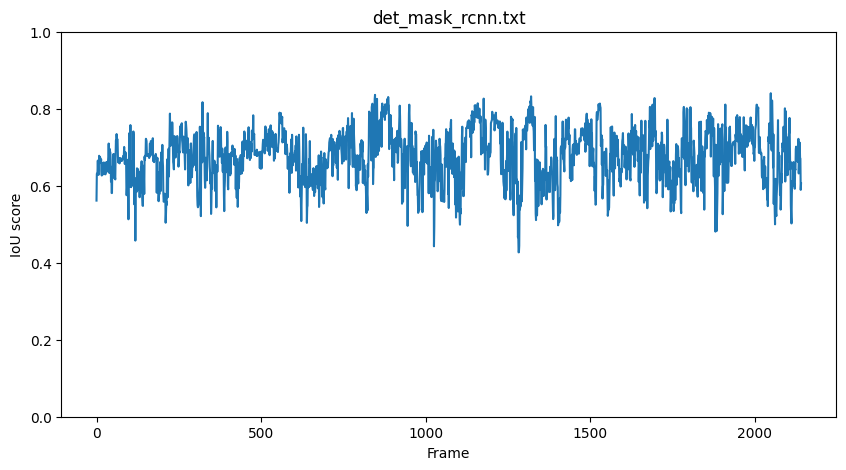

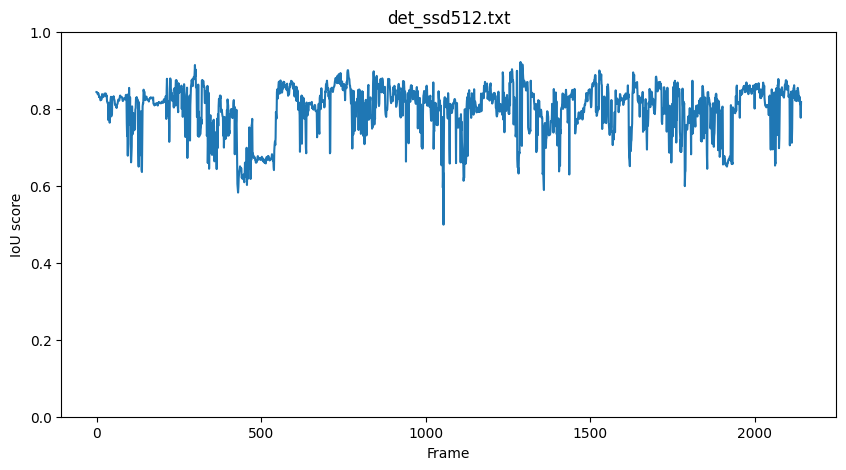

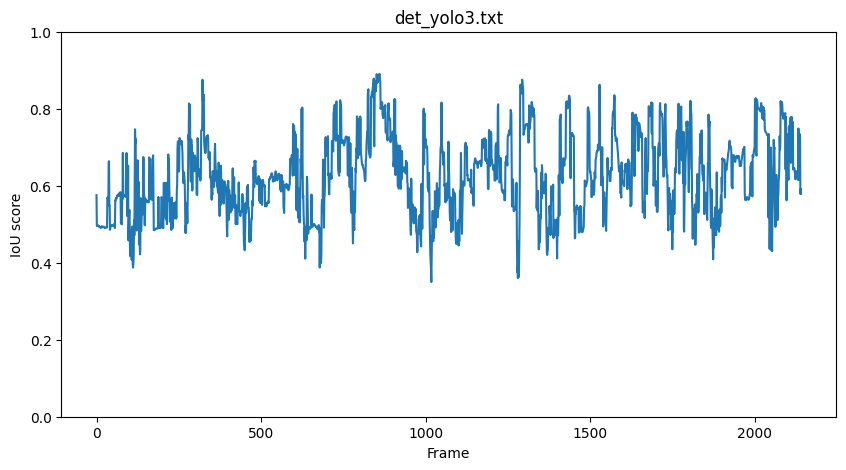

In [13]:
paths = [maskrcnn,yolo,ssd]
for path in paths:
    boxes = load_from_txt(path)
    boxes.sort(key=lambda x:x[-1], reverse=True)
    mIOU, mIOU_frame ,AP = mean_AP_Pascal_VOC(gt_boxes,total,boxes,iou_th=0.5)

    # Plot the IoU score for each frame
    plt.figure(figsize=(10,5))
    # Set title
    plt.title(path.split('/')[-1])
    frames = list(mIOU_frame.keys())
    # Sort the frames
    frames.sort(key=lambda x: int(x.split('_')[1]))
    # Convert frames to a list of integers
    frames_num = [int(frame.split('_')[1]) for frame in frames]
    iou_scores = [np.mean(mIOU_frame[frame]) for frame in frames]
    plt.plot(frames_num, iou_scores)
    plt.xlabel('Frame')
    plt.ylabel('IoU score')
    # y from 0 to 1
    plt.ylim(0,1)
    plt.show()


[[558.36, 94.45, 663.49, 169.31], [573.7, 72.89, 661.41, 145.05], [913.24, 93.02, 972.14, 144.57], [894.24, 95.32, 944.92, 144.0], [878.4, 107.28, 927.5, 145.72], [1176.01, 82.17, 1253.12, 174.08], [1285.84, 363.23, 1516.36, 546.91], [931.96, 78.33, 1013.32, 146.01]]
[['f_0', 1288.141, 359.726, 1513.959, 536.2860000000001, '0.997'], ['f_0', 1179.756, 101.191, 1228.438, 155.595, '0.936'], ['f_0', 882.263, 92.697, 938.0740000000001, 140.233, '0.906'], ['f_0', 928.162, 79.277, 1010.438, 145.785, '0.665'], ['f_0', 915.095, 92.916, 944.345, 139.063, '0.491'], ['f_0', 925.099, 80.011, 1011.964, 145.014, '0.471'], ['f_0', 874.296, 108.25, 906.82, 139.809, '0.342'], ['f_0', 836.914, 89.223, 943.821, 138.248, '0.255'], ['f_0', 686.268, 63.712, 704.994, 81.273, '0.227']]


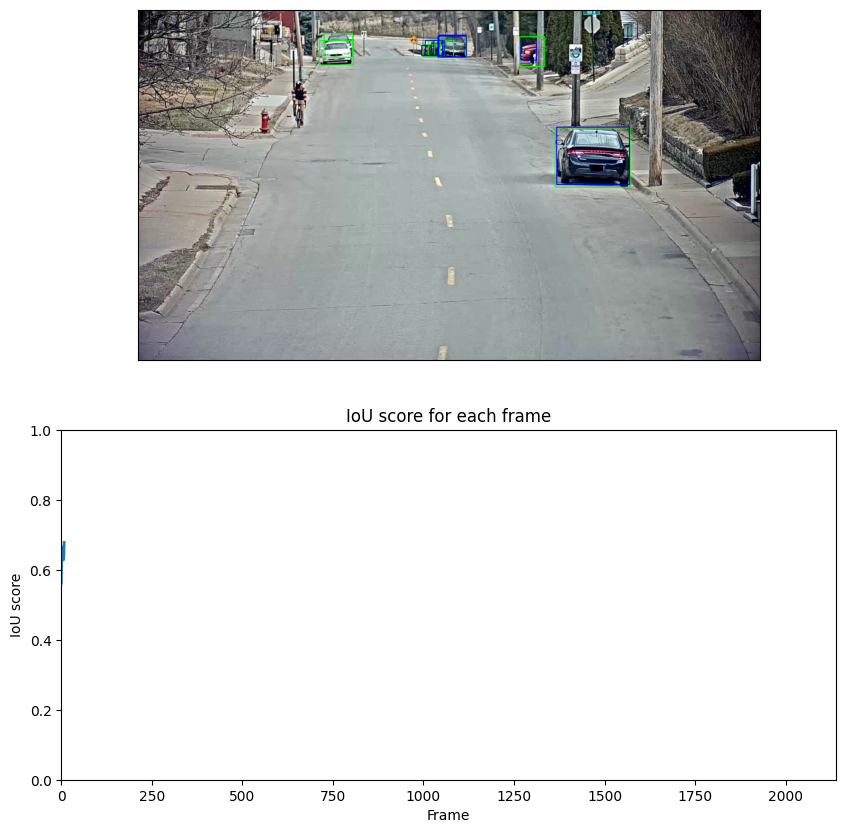

In [14]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def group_by_frame(predicted_boxes):
    """Group the detected boxes by frame_id as a dictionary"""
    predicted_boxes.sort(key=lambda x: x[0])
    predicted_boxes = itertools.groupby(predicted_boxes, key=lambda x: x[0])
    predicted_boxes = {k: list(v) for k, v in predicted_boxes}
    return predicted_boxes

def create_animation(path, gt_boxes, predicted_boxes, video_capture):
    """Create an animation of the IoU score for each frame"""
    # Group the detected boxes by frame_id as a dictionary
    predicted_boxes_group = group_by_frame(predicted_boxes)
    # Get the IoU score for each frame in format dict {frame_id: [iou_score1, iou_score2, ...]}
    mIOU, mIOU_frame ,AP = mean_AP_Pascal_VOC(gt_boxes,total,predicted_boxes,iou_th=0.5)
    # Get the frame_id list
    frames_id = list(mIOU_frame.keys())
    # Sort the frames list
    frames_id.sort(key=lambda x: int(x.split('_')[1]))
    frames_num = [int(frame.split('_')[1]) for frame in frames_id]
    # Get the IoU score list
    iou_scores = [np.mean(mIOU_frame[frame]) for frame in frames_id]
    # Get the video fps
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    # Get the video width
    width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    # Get the video height
    height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create a figure
    fig = plt.figure(figsize=(10, 10))

    # Create a subplot for the video frames
    ax1 = fig.add_subplot(211)
    # Hide the x and y ticks and labels
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Create a subplot for the IoU line plot
    ax2 = fig.add_subplot(212)
    # Set the title
    ax2.set_title('IoU score for each frame')
    # Set the x label
    ax2.set_xlabel('Frame')
    # Set the y label
    ax2.set_ylabel('IoU score')
    # Set the x axis range
    ax2.set_xlim(0, frames_num[-1])
    # Set the y axis range
    ax2.set_ylim(0, 1)
    # Create a line
    line, = ax2.plot([], [], lw=2)

    print(gt_boxes[frames_id[0]])
    print(predicted_boxes_group[frames_id[0]])

    # Create a function to initialize the animation
    def init():
        line.set_data([], [])
        # text.set_text('')
        return line, 
    
    # Create a function to update the animation
    def animate(i):
        # Update IoU line plot
        line.set_data(frames_num[:i], iou_scores[:i])
        
        # # Update video frames
        ret, frame = video_capture.read()
        if ret:
            # Convert the frame to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Draw the ground truth boxes
            for box in gt_boxes[frames_id[i]]:
                cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
            # Draw the predicted boxes
            for box in predicted_boxes_group[frames_id[i]]:
                cv2.rectangle(frame, (int(box[1]), int(box[2])), (int(box[3]), int(box[4])), (0, 0, 255), 2)
            # Set the frame to the subplot in rgb format
            ax1.imshow(frame)

        return line,


    # # Create the animation
    ani = animation.FuncAnimation(
        fig, animate, frames=10, init_func=init)#, interval=1000/fps, blit=True, repeat=False)

    ani.save(f'Prova.mp4', fps=fps, bitrate=-1,
            extra_args=['-vcodec', 'libx264'])

gt_boxes,total = load_from_xml('/home/guillem/mcv-m6-2023-team6/dataset/ai_challenge_s03_c010-full_annotation.xml')
predicted_boxes = load_from_txt('/home/guillem/mcv-m6-2023-team6/dataset/AICity_data/train/S03/c010/det/det_mask_rcnn.txt')
predicted_boxes.sort(key=lambda x:x[-1], reverse=True)
video_capture = cv2.VideoCapture('/home/guillem/mcv-m6-2023-team6/dataset/AICity_data/train/S03/c010/vdo.avi')
create_animation('/home/guillem/mcv-m6-2023-team6/dataset/AICity_data/train/S03/c010/vdo.avi', gt_boxes, predicted_boxes, video_capture)
